In [84]:
import pickle

with open('../data/processed/weatherAU-processed.pkl', 'rb') as f:
    df = pickle.load(f)

df.columns.to_numpy()

array(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RISK_MM', 'RainTomorrow'], dtype=object)

In [85]:
# Set features and target data
features = df[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
               'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 
               'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
               'Humidity3pm', 'Pressure9am', 'Pressure3pm',  'Cloud9am', 
               'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']]
target = df['RainTomorrow']

# Split dataset into train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=28732)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [86]:
import matplotlib.pyplot as plt

def plot_roc_curve(fper, tper):
    plt.figure(figsize=(6,4))
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0,1], [0,1], color='darkblue', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristics (ROC) curve')
    plt.legend()
    plt.show()

In [110]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, ConfusionMatrixDisplay

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t_0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t_0
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen Kappa = {}".format(coh_kap))
    print(classification_report(y_test, y_pred, digits=5))
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    
    plot_roc_curve(fper, tper)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, normalize='all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7875968662181725
ROC Area under Curve = 0.7676397368390366
Cohen Kappa = 0.5449124358772648
              precision    recall  f1-score   support

           0    0.80740   0.85712   0.83152     28724
           1    0.75096   0.67816   0.71270     18248

    accuracy                        0.78760     46972
   macro avg    0.77918   0.76764   0.77211     46972
weighted avg    0.78547   0.78760   0.78536     46972



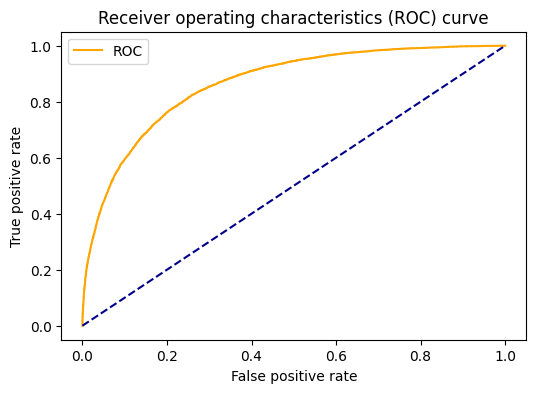

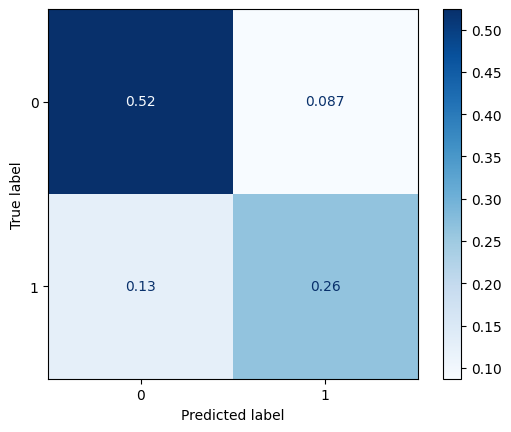

In [111]:
# Training rainfall prediction with different models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.8655369156092991
ROC Area under Curve = 0.8658035582536383
Cohen Kappa = 0.7210721920963317
              precision    recall  f1-score   support

           0    0.91097   0.86461   0.88719     28724
           1    0.80269   0.86700   0.83361     18248

    accuracy                        0.86554     46972
   macro avg    0.85683   0.86580   0.86040     46972
weighted avg    0.86891   0.86554   0.86637     46972



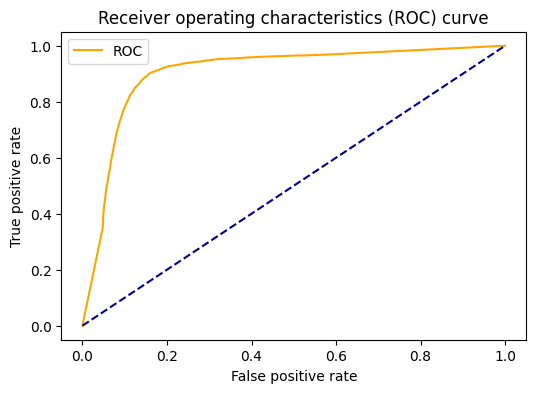

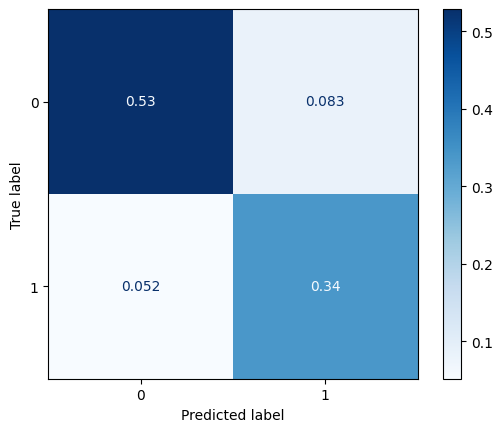

In [113]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 16, 'max_features': 'sqrt'}
model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8861662266882399
ROC Area under Curve = 0.8804025260043415
Cohen Kappa = 0.7605086548257622
              precision    recall  f1-score   support

           0    0.90748   0.90625   0.90686     28724
           1    0.85274   0.85456   0.85365     18248

    accuracy                        0.88617     46972
   macro avg    0.88011   0.88040   0.88025     46972
weighted avg    0.88621   0.88617   0.88619     46972



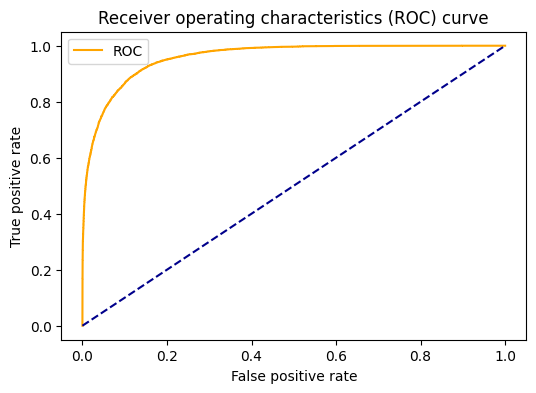

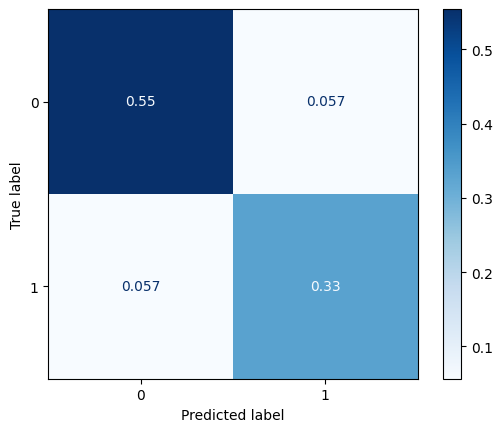

In [90]:
# Neural Network
from sklearn.neural_network import MLPClassifier
params_nn = {
    'hidden_layer_sizes': (30,30,30),
    'activation': 'logistic',
    'solver': 'lbfgs',
    'max_iter': 500
}
model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8743719662777825
ROC Area under Curve = 0.869479890580268
Cohen Kappa = 0.7364795287277861
              precision    recall  f1-score   support

           0    0.90200   0.89141   0.89667     28724
           1    0.83218   0.84754   0.83979     18248

    accuracy                        0.87437     46972
   macro avg    0.86709   0.86948   0.86823     46972
weighted avg    0.87487   0.87437   0.87458     46972



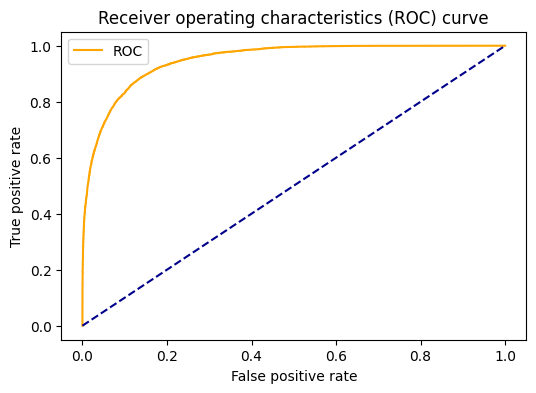

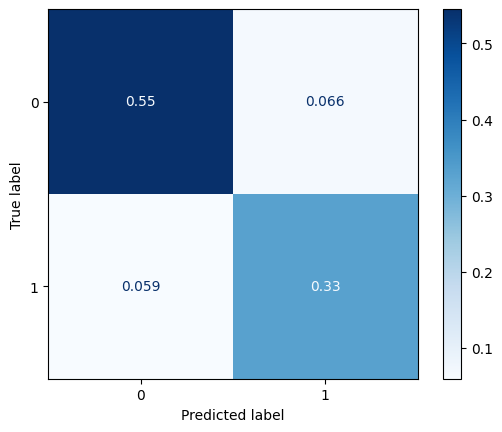

In [91]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
params_rf = {
    'max_depth': 16,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 512
}
model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_nn, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8840372988163161
ROC Area under Curve = 0.8785219163337223
Cohen Kappa = 0.7562050144856384
              precision    recall  f1-score   support

           0    0.90676   0.90325   0.90500     28724
           1    0.84863   0.85379   0.85120     18248

    accuracy                        0.88404     46972
   macro avg    0.87769   0.87852   0.87810     46972
weighted avg    0.88417   0.88404   0.88410     46972



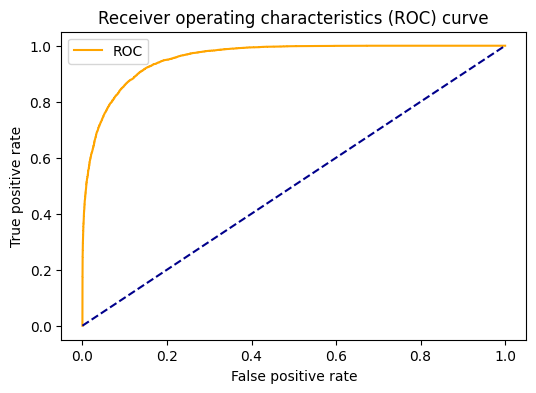

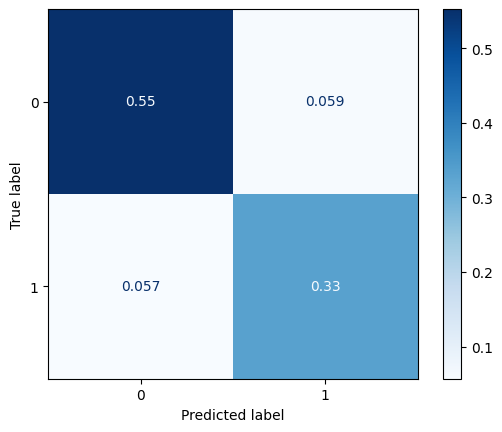

In [92]:
# XGBoost
from xgboost import XGBClassifier
params_xgb = {
    'n_estimators': 500,
    'max_depth': 16
}
model_xgb = XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_nn, X_train, y_train, X_test, y_test)

Accuracy  Time taken
0.787597  2.121866      1
0.865537  0.383037      1
0.874372  265.497801    1
0.884037  276.506320    1
0.886166  265.442152    1
Name: count, dtype: int64


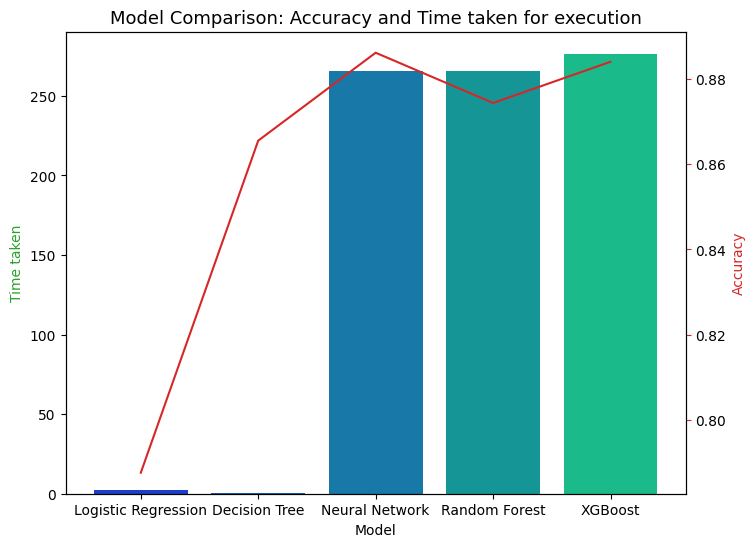

In [115]:
import pandas as pd
import seaborn as sns

accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
model_data = pd.DataFrame(model_data)

score = model_data[['Accuracy', 'Time taken']].value_counts()
print(score)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Time taken', fontsize=10, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = model_data, hue='Model', legend=False, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=10, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = model_data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

ROC_AUC   Cohen_Kappa
0.767685  0.545004       1
0.864614  0.719684       1
0.869480  0.736480       1
0.878522  0.756205       1
0.880403  0.760509       1
Name: count, dtype: int64


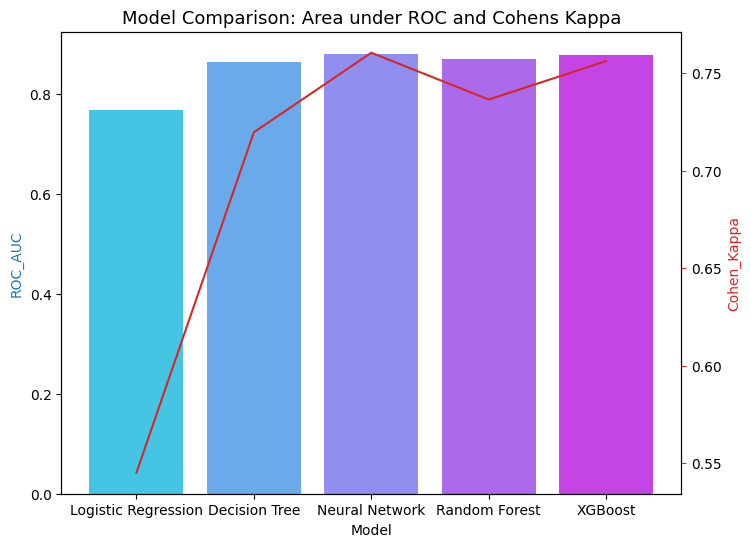

In [114]:
score = model_data[['ROC_AUC', 'Cohen_Kappa']].value_counts()
print(score)

fig, ax3 = plt.subplots(figsize=(8,6))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=10)
ax3.set_ylabel('ROC_AUC', fontsize=10, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = model_data, hue='Model', legend=False, palette='cool')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=10, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = model_data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()